# Домашнее задание по обучению сверточной сети

В этом задании вы сами (с небольшой помощью) обучите нейронную сеть для классификации кошек и собак!

Ниже приводится код для считывания данных аналогичный прошлому уроку, поэтому можете его просто запустить.

*Не забудьте добавить в Runtime GPU для ускорения вычислений*.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-05-03 10:26:38.349380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 10:26:39.240174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-05-03 10:26:40.064093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 10:26:40.099457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 10:26:40.099722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [5]:
! ls ~/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [6]:
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [7]:
num_cats_tr = len(list(train_cats_dir.glob("*")))
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [25]:
BATCH_SIZE = 50
IMG_SHAPE  = 100

In [26]:
train_image_generator      = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [27]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
sample_training_images, sample_labels = next(train_data_gen)

In [29]:
_val_images, _val_labels = next(val_data_gen)
next(val_data_gen)[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [30]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

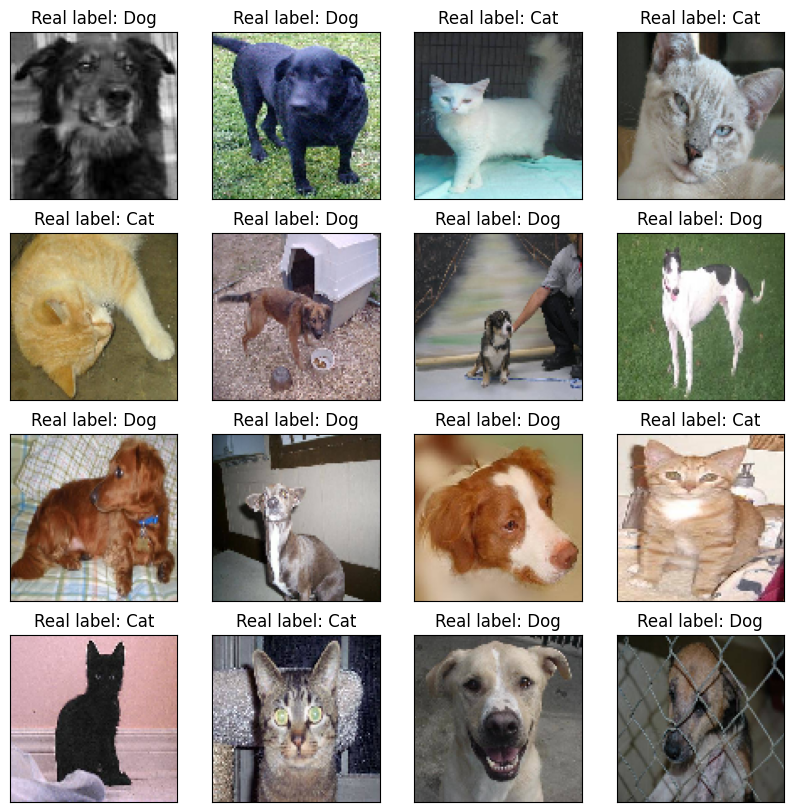

In [31]:
show_catsdogs(sample_training_images, sample_labels)

# Определение модели

**Задание**

Определите модель аналогично модели из урока с классификации одежды.

1. Используйте сверточные слои с размером фильтра (3,3) и relu активацией. Можно оставить паддинг по умолчанию.
2. После каждого сверточного слоя применяйте MaxPool, уменьшающий размер в два раза
3. Увеличивайте количество фильтров в два раза после каждого пуллинга до 128, начиная с 32. Таким образом вы добывите три блока conv+pool
4. Добавьте еще один conv+pool блок с 128 фильтрами
5. Используйте Flatten(), чтобы превратить последний тензор в вектор
6. Добавьте полносвязный слой на 128 признаков
7. Добавьте выходной слой с активацией sigmoid



In [32]:
# < YOUR CODE STARTS HERE >

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# < YOUR CODE ENDS HERE >
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [33]:
# должно получиться около 1 000 000 параметров
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,233 (1.92 MB)

 Trainable params: 503,233 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# для более удобного и наглядного отображения обучения мы воспользуемся библиотекой,
# которая реализует коллбек, отображающий кривые обучения в режиме реального времени.
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

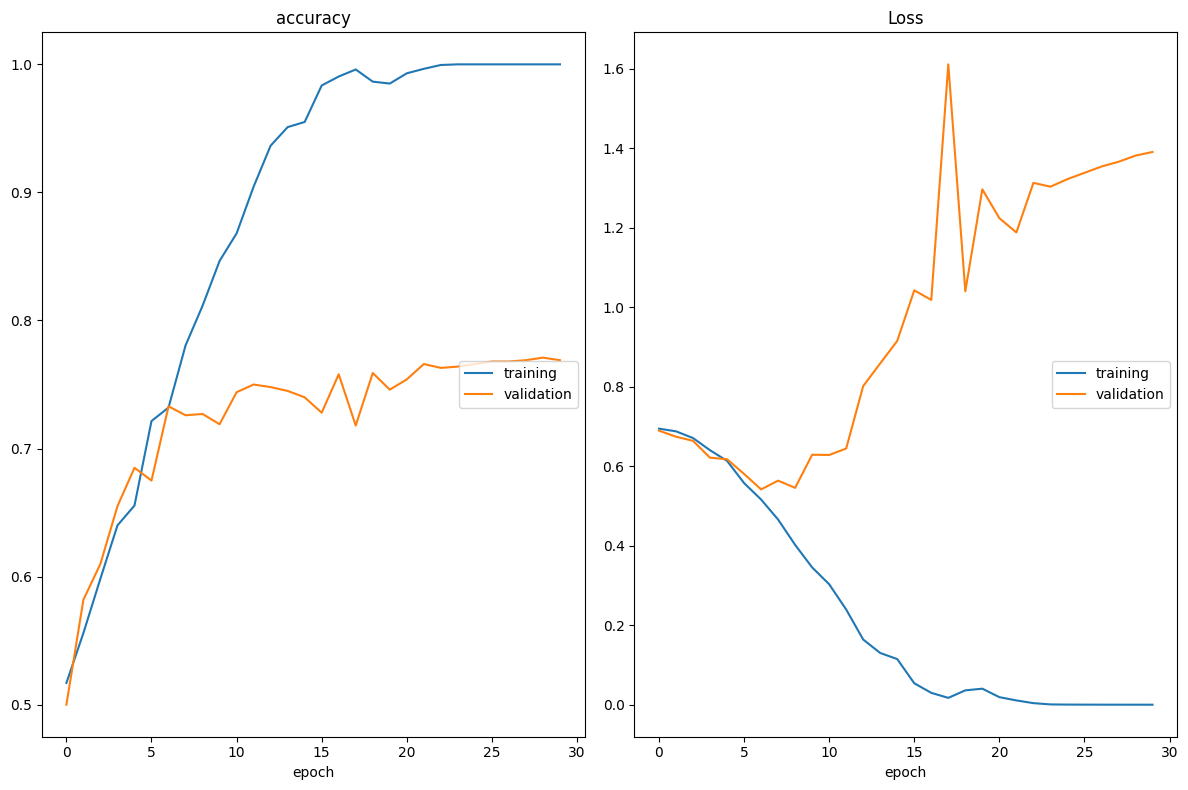

accuracy
	training         	 (min:    0.517, max:    1.000, cur:    1.000)
	validation       	 (min:    0.500, max:    0.771, cur:    0.769)
Loss
	training         	 (min:    0.000, max:    0.695, cur:    0.000)
	validation       	 (min:    0.542, max:    1.612, cur:    1.391)
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 1.0000 - loss: 1.8480e-04 - val_accuracy: 0.7690 - val_loss: 1.3912


In [35]:
# указанными параметрами спустя 30 эпох вы увидите точность около 75%.
# если вас что-то насторожит в графиках, запомните это, это нормально :)
EPOCHS = 30
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()]) # мы добавили коллбек для отрисовки прогресса

Теперь посмотрим на предсказания нашей сети:

Found 1000 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


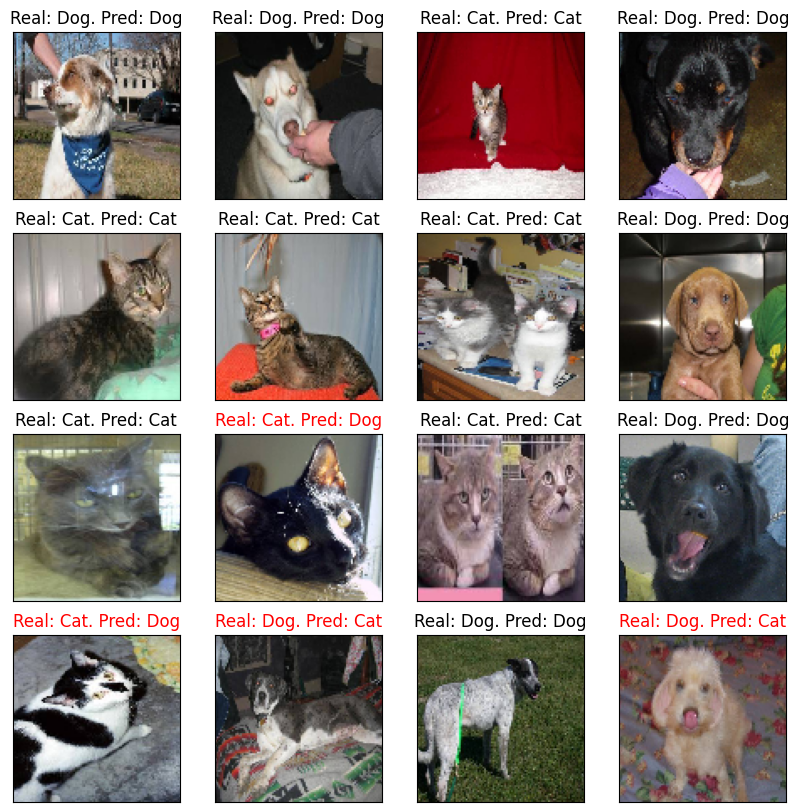

In [52]:
shuffle_val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')
sample_validation_images, sample_validation_labels = next(shuffle_val_data_gen)
predict_x=model.predict(sample_validation_images).flatten()
predicted=(predict_x > 0.5).astype(int)
# predicted = model.predict_classes(sample_validation_images).flatten()
show_catsdogs(sample_validation_images, sample_validation_labels, predicted)

 # Заключение

 В этом задании вы получили классификатор кошек и собак, который имеет точность на валидации около 75%. Поздравляем!

Но вы не могли не заметить, что точность на трейне -- 100%. Это явный признак переобучения. Сможем ли мы избавиться от переобучения? Увидим с следующем уроке.